In [21]:
# gpu support
# may need to install nvidia drivers etc ref: https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html
!git clone --recursive https://github.com/microsoft/LightGBM
!cd LightGBM
!mkdir build
!cd build
!cmake -DUSE_GPU=1
!make -j$(nproc)
!cd ..


Cloning into 'LightGBM'...
remote: Enumerating objects: 27143, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 27143 (delta 147), reused 189 (delta 115), pack-reused 26891
Receiving objects: 100% (27143/27143), 19.57 MiB | 37.53 MiB/s, done.
Resolving deltas: 100% (20075/20075), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/home/ubuntu/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote

2022-08-20 07:13:15,681 - distributed.nanny - WARNING - Restarting worker
2022-08-20 07:13:15,684 - distributed.nanny - WARNING - Restarting worker
2022-08-20 07:13:15,860 - distributed.nanny - WARNING - Restarting worker
2022-08-20 07:13:16,178 - distributed.nanny - WARNING - Restarting worker
2022-08-20 07:13:17,144 - distributed.nanny - WARNING - Restarting worker
2022-08-20 07:13:17,147 - distributed.nanny - WARNING - Restarting worker
2022-08-20 07:13:17,335 - distributed.nanny - WARNING - Restarting worker
2022-08-20 07:13:17,635 - distributed.nanny - WARNING - Restarting worker


CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


CMake Error: The source directory "/home/ubuntu" does not appear to contain CMakeLists.txt.
Specify --help for usage, or press the help button on the CMake GUI.
make: *** No targets specified and no makefile found.  Stop.


In [ ]:
!pip install lightgbm
!pip install dask[complete]
!pip install sklearn

In [2]:
import numpy as np
import lightgbm as lgb
import pandas as pd
import dask.dataframe as dd
import matplotlib


In [4]:
from distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
# client.restart()
# client.close()
# client.shutdown()

/home/ubuntu/env/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42701 instead
  warnings.warn(


In [30]:
%%time

# dask
# https://youtu.be/lPcX2xev0ho

training_features = dd.read_csv("./originalDataset/train_data.csv", blocksize=25e6)
training_label = dd.read_csv("./originalDataset/train_labels.csv", blocksize=25e6)

training_merged = training_features.merge(
    training_label, 
    how="outer", 
    on=["customer_ID"]
)

# training_merged.compute()
# training_merged.head(n=5)





CPU times: user 238 ms, sys: 28 ms, total: 266 ms
Wall time: 252 ms


In [31]:
%%time
# https://towardsdatascience.com/parallelizing-feature-engineering-with-dask-3db88aec33b7
# feature engineering
categorical_feature_array=[
        "B_30", "B_38", "D_114", 
        "D_116", "D_117", "D_120",
        "D_126", "D_64",
        "D_66", "D_68"
]
# removed column D_63 because had ML algo (fit) couldn't understand the column & couldn't properly change type 


def feature_engineering(dataframe):
        # dataframe["D_63"] = dataframe["D_63"].astype("category")
        # dataframe["D_64"] = dataframe["D_64"].astype("category")

        dataframe[categorical_feature_array] = dataframe[categorical_feature_array].astype("category")

        
        dataframe["S_2"] = dd.to_datetime(dataframe["S_2"])
        dataframe["month"] = dataframe["S_2"].dt.month
        dataframe["day"] = dataframe["S_2"].dt.dayofweek
        dataframe["year"] = dataframe["S_2"].dt.year

        dataframe["D_63"] = dataframe["D_63"].astype("category")
        return dataframe.drop(columns=["S_2"])
        # note dropping D_63 column, loses some information, also alt convert sin cos time 

training_merged = feature_engineering(training_merged)

# learn dask
# https://youtu.be/lPcX2xev0ho

CPU times: user 426 ms, sys: 35.9 ms, total: 462 ms
Wall time: 431 ms


In [ ]:
# print(training_merged[["D_63","D_64"]].dtypes)
# print(training_merged["D_64"].head(n=5))
# training_merged["D_63"].nunique().compute()
# training_merged["D_64"].nunique().compute()

In [32]:
%%time
# features = training_merged[training_merged.columns[training_merged.columns!="target"]]
# label = training_merged["target"]

# must create training set, validation set, & test set using training_merged to train, validate, & test model



training_set, validation_set, test_set = training_merged.random_split([0.8, 0.1, 0.1], random_state=123)

train_x = training_set.drop(columns=["target","customer_ID"]).compute()
train_y = training_set["target"].compute()

val_x = validation_set.drop(columns=["target","customer_ID"]).compute()
val_y = validation_set["target"].compute()

test_x = test_set.drop(columns=["target","customer_ID"]).compute()
test_y = test_set["target"].compute()


In [28]:
%%time

# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html
# https://lightgbm.readthedocs.io/en/latest/Parallel-Learning-Guide.html#dask
# https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/
# model development



# https://lightgbm.readthedocs.io/en/latest/Parameters.html
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy



params = {
    # change accuracy, use dart bosoting type?
    "num_leaves" : 140,
    "max_bin" : 255,
    "learning_rate" : 0.7,
    "boosting_type" : "dart",
    "num_iterations" : 500,
    "n_estimators" : 220,
    

    # change overfitting
    "max_depth" : -1,
    "min_split_gain" : 0,
    "min_child_samples" : 20,
    "reg_alpha" : 0,
    "reg_lambda" : 0,
    "early_stopping" : 5,
    "feature_pre_filter" : True,

    
    "scale_pos_weight" : 4,

    # gpu, however, using CPU instance this time
    # "device_type" : "gpu",
    # "gpu_platform_id" : 0,
    # "gpu_device_id" : 0,

    # misc
    "verbose" : -1,
    "objective" : "binary",
    "num_threads" : 16,
    "random_state" : 42
}



# model = lgb.LGBMClassifier(client=client, **params)
model = lgb.LGBMClassifier(**params)



CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 62.5 µs


In [29]:
%%time

model.fit(
    train_x,
    train_y,
    eval_set=[(val_x, val_y),(train_x, train_y)],
    eval_metric="logloss"
    # ,categorical_feature=categorical_feature_array
)



NameError: name 'train_x' is not defined

In [22]:
print(f"Training accuracy: {model.score(train_x, train_y)}")
print(f"Validation accuracy: {model.score(val_x, val_y)}")
print(f"Test accuracy: {model.score(test_x, test_y)}")

Training accuracy: 0.9627419195552154
Validation accuracy: 0.9220814918226073
Test accuracy: 0.921321071744747


In [21]:
# pickle model when done?
model.booster_.save_model("mod3.txt")

              precision    recall  f1-score   support

           0       0.98      0.91      0.95    415728
           1       0.78      0.95      0.86    137762

    accuracy                           0.92    553490
   macro avg       0.88      0.93      0.90    553490
weighted avg       0.93      0.92      0.92    553490

CPU times: user 9min 51s, sys: 1.28 s, total: 9min 52s
Wall time: 41 s


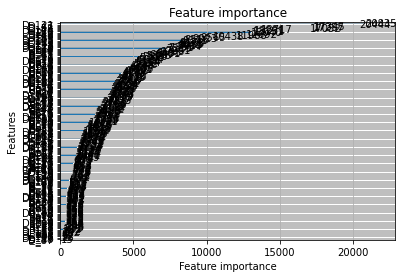

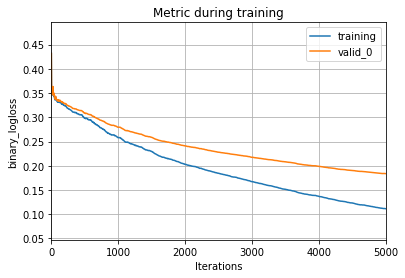

In [23]:
%%time
# https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/
# Additional
from sklearn.metrics import classification_report
lgb.plot_importance(model)
lgb.plot_metric(model)
print(classification_report(test_y,model.predict(test_x)))

In [12]:
model = lgb.Booster(model_file = "mod3.txt")

In [9]:
%%time
# make predictions on test_data features and reference sample_submission for format
test_features_with_ID = dd.read_csv("./originalDataset/test_data.csv")

# changes features to match what was used to train model
test_features_with_ID = feature_engineering(test_features_with_ID)

customer_ID = test_features_with_ID["customer_ID"]





CPU times: user 447 ms, sys: 61.8 ms, total: 509 ms
Wall time: 466 ms


In [10]:
# changes features to match what was used to train model
test_features = test_features_with_ID.drop(columns=["customer_ID"])
# running .compute on huge dataset causes crash?


In [13]:
# booster.predict
pred_y = model.predict(test_features.compute())

# lightgbm.predict
# pred_y = model.predict(test_features.compute())

# if booster.predict (loaded the model) spits out probability instead of 0 or 1
# if lightgbm.predict, spits out 0 or 1
# https://stackoverflow.com/questions/71813904/why-lightgbm-with-objective-binary-donot-return-binary-value-0-and-1-when-c

In [23]:
# convert probability to class if booster.predict
pred_y = (pred_y > 0.5).astype("int")

In [26]:
submission = pd.DataFrame({"customer_ID": customer_ID, "prediction": pred_y})
# you could use any filename. We choose submission here
submission.drop_duplicates(subset="customer_ID", keep="first", inplace=True)
submission.to_csv("submit_mod3_dropdup.csv", index=False)

In [27]:
# in cli
# kaggle competitions submit -c [COMPETITION] -f [FILE] -m [MESSAGE]
# https://stackoverflow.com/questions/51059644/kaggle-file-sumbission-error-santander-value-prediction-challenge
# ^ solve xx has already been defined
!kaggle competitions submit -c amex-default-prediction -f submit_mod3_dropdup.csv -m "first submit"

100%|██████████████████████████████████████| 59.1M/59.1M [00:01<00:00, 50.9MB/s]
Successfully submitted to American Express - Default Prediction